In [13]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
from read_data import DataLoader
import plotly.express as px
import plotly.graph_objects as go
# === Configuration ===
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_palette("viridis")

In [ ]:

loader = DataLoader()
url= loader.url 
df = loader.load_data_Eda(url)

DataLoader initialized. Data already loaded in variable 'df'.


In [5]:
print("===Dataset Overview===")
def print_overview(df):
    print(f"Number of rows: {df.shape[0]}")
    print(f"Number of columns: {df.shape[1]}")
    print("Columns:")
    for col in df.columns:
        print(f"- {col}")
    print("\nFirst 5 rows:")
    print(df.head())

if __name__ == "__main__":
    print_overview(df)
    print("\n===End of Overview===")

===Dataset Overview===
Number of rows: 1441
Number of columns: 17
Columns:
- Global_active_power
- Global_reactive_power
- Voltage
- Global_intensity
- Sub_metering_1
- Sub_metering_2
- Sub_metering_3
- temp
- humidity
- conditions
- day_of_week
- day_of_month
- month
- year
- is_weekend
- season
- is_holiday

First 5 rows:
            Global_active_power  Global_reactive_power  Voltage  \
datetime                                                          
2006-12-17                1.044                  0.152   242.73   
2006-12-18                0.278                  0.126   246.17   
2006-12-19                0.414                  0.242   241.19   
2006-12-20                0.824                  0.058   245.57   
2006-12-21                1.814                  0.148   243.51   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-17               4.4             0.0

''This dataset provides 1441 rows and (11 columns from original) + (6 columns added) in total 17 for EDA. The dataframe containing information related to electricity consumption and environmental conditions over time.

Energy Metrics: Includes Global_active_power, Global_reactive_power, Voltage, and Global_intensity—useful for analyzing energy trends.

Sub Metering Data: Three sub-metering columns measure energy use in different locations.

Weather Influence: Temperature, humidity, and weather conditions provide context on how environmental factors may impact energy usage.

Date Range: Starts from December 17, 2006, showing daily energy data alongside weather conditions.

The first few rows suggest variability in power consumption and environmental factors. For example, the humidity levels fluctuate between 72.3% and 91.1%, while temperature remains low.''

In [6]:
# Check statistics, missing values, and data types
print("\n===Data Types and Missing Values===")
df_dtypes_missing = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Values': df.isnull().sum()
}).reset_index().rename(columns={'index': 'Column'})
print(df_dtypes_missing) 
print("\n===Descriptive Statistics===") 
df.describe()


===Data Types and Missing Values===
                   Column Data Type  Missing Values
0     Global_active_power   float64               0
1   Global_reactive_power   float64              15
2                 Voltage   float64              15
3        Global_intensity   float64              15
4          Sub_metering_1   float64              15
5          Sub_metering_2   float64              15
6          Sub_metering_3   float64              15
7                    temp   float64               0
8                humidity   float64               0
9              conditions    object               0
10            day_of_week     int32               0
11           day_of_month     int32               0
12                  month     int32               0
13                   year     int32               0
14             is_weekend     int32               0
15                 season     int32               0
16             is_holiday     int32               0

===Descriptive Statistics=

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,day_of_week,day_of_month,month,year,is_weekend,season,is_holiday
count,1441.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1426.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.000000,1441.0
mean,0.745414,0.116410,242.672195,3.162973,0.532258,0.697055,3.308555,12.188494,72.586676,2.998612,15.774462,6.449688,2008.437196,0.285219,2.515614,0.0
std,0.791657,0.100699,2.770333,3.292621,4.249666,3.454682,6.499891,6.437531,11.663047,2.000694,8.791793,3.416525,1.128718,0.451675,1.108646,0.0
min,0.080000,0.000000,229.400000,0.200000,0.000000,0.000000,0.000000,-4.720000,35.100000,0.000000,1.000000,1.000000,2006.000000,0.000000,1.000000,0.0
25%,0.290000,0.048000,241.232500,1.200000,0.000000,0.000000,0.000000,7.560000,64.600000,1.000000,8.000000,3.000000,2007.000000,0.000000,2.000000,0.0
50%,0.398000,0.100000,242.880000,1.800000,0.000000,0.000000,0.000000,12.440000,73.700000,3.000000,16.000000,6.000000,2008.000000,0.000000,3.000000,0.0
75%,0.950000,0.186000,244.370000,4.000000,0.000000,1.000000,1.000000,17.500000,81.400000,5.000000,23.000000,9.000000,2009.000000,1.000000,3.000000,0.0
max,5.806000,0.588000,251.710000,24.400000,40.000000,74.000000,20.000000,27.220000,97.100000,6.000000,31.000000,12.000000,2010.000000,1.000000,4.000000,0.0


#### Initial checking :  15 null values in energy related variables

In [9]:
df=df.ffill()  # Forward fill to handle missing values

# Simplify weather conditions
def simplify_weather(condition):
    condition = str(condition).lower()
    if 'snow' in condition:
        return 'Snow'
    elif 'rain' in condition:
        return 'Rain'
    elif 'overcast' in condition:
        return 'Overcast'
    elif 'cloudy' in condition:
        return 'Cloudy'
    elif 'clear' in condition:
        return 'Clear'
    else:
        return 'Other'

df['Weather_Type'] = df['conditions'].apply(simplify_weather)

#### Here we create some new columns to see trends and seonality per different time periods

In [26]:
# Step 1: Convert kW to Wh per minute (Global_active_power is in kW)
df['GAP_wh'] = df['Global_active_power'] * 1000 / 60
# Step 2: Sum all sub meterings
df['sub_metering_total'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
# Step 3: Calculate unmetered power
df['sub_metering_other'] = df['GAP_wh'] - df['sub_metering_total']

df['Monthly']=df.groupby(df['month'])['GAP_wh'].transform('mean')

# plot monthly average for global active power and sub metering using plotly and seaborn
def plot_monthly_average(df):
    # Group by 'month' and calculate mean for all relevant columns
    monthly_avg = df.groupby('month')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_other']].mean().reset_index()
    monthly_avg['month'] = monthly_avg['month'].apply(lambda x: calendar.month_name[x])

    fig = px.bar(
        monthly_avg,
        x='month',
        y=[ 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'sub_metering_other'],
        title='Monthly Average Global Active Power and Sub Metering',
        labels={'value': 'Average (Wh)', 'variable': 'Type'},
        barmode='group'
    )
    fig.show()

# Plot monthly average
plot_monthly_average(df)

- Sub_metering_1 : kitchen appliances (such as dishwasher, oven, microwave)
    - Shows relatively low consumption (mostly below 1 Wh) with slight increases in February and July
- Sub_metering_2 : laundry room equipment (washing machine, tumble-dryer, refrigerator, etc.)
    - Also shows low consumption (mostly below 1 Wh) with January showing the highest usage
- Sub_metering_3 : electric water heater and air conditioner
    - Shows moderate consumption (around 3-5 Wh) with highest usage in January and February
- sub_metering_other : Represents all other energy consumption not measured by the first three sub-meters
                This includes lighting circuits, general outlets, and other electrical devices not covered by the specific sub-meters
    - Consistently shows the highest consumption (6-10 Wh) with peaks in February and December

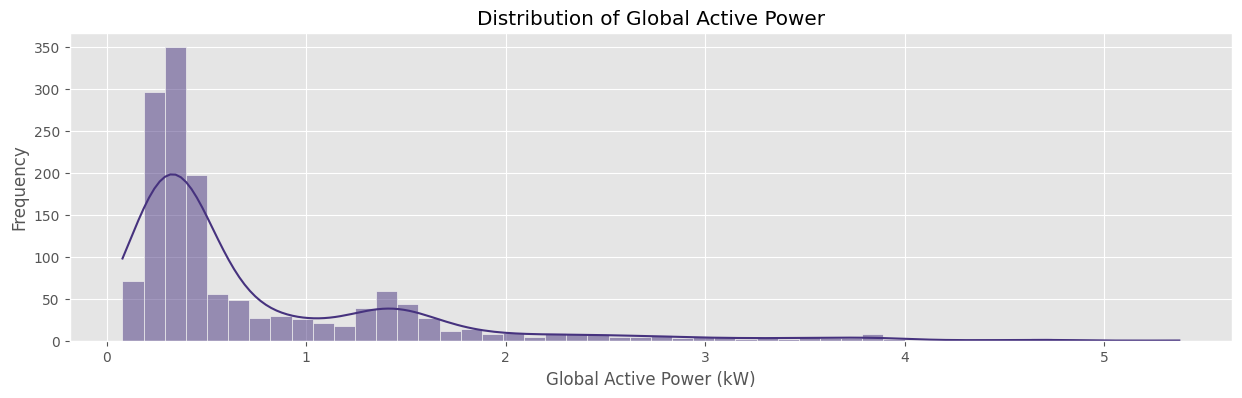

In [36]:

# === Check distribution of Global Active Power ===
plt.figure(figsize=(15, 4))
sns.histplot(df['Global_active_power'], bins=50, kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.show()

**Shape & Skewness:**

- Most energy consumption values are concentrated in the lower range (0-1 kW)
- Extends to approximately 5 kW, indicating occasional high consumption periods
- Approximately 0.4-0.5 kW (most common consumption level)
- About 80% of observations fall below 1 kW
- Values above 3 kW are relatively rare but present

### Observation of outliers

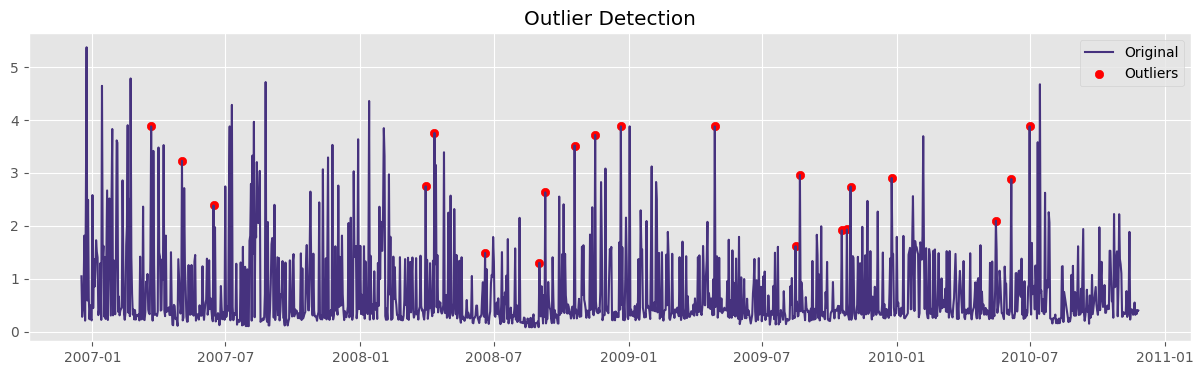

Detected 21 outliers


In [37]:
from scipy import stats
def detect_outliers(series, method='iqr', window=30, threshold=3):
    """
    Detect outliers using specified method
    """
    if method == 'iqr':
        # IQR method (robust for skewed distributions)
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        return (series < lower_bound) | (series > upper_bound)
    
    elif method == 'zscore':
        # Z-score method (for normal distributions)
        z = np.abs(stats.zscore(series))
        return z > threshold
    
    elif method == 'rolling':
        # Time-aware rolling z-score
        mean = series.rolling(window=window, min_periods=1).mean()
        std = series.rolling(window=window, min_periods=1).std()
        z = np.abs((series - mean) / std)
        return z > threshold
    
    elif method == 'mad':
        # Median Absolute Deviation (robust)
        median = series.median()
        mad = np.abs(series - median).median()
        modified_z = 0.6745 * (series - median) / mad
        return np.abs(modified_z) > threshold
    
    else:
        raise ValueError("Invalid method. Choose: 'iqr', 'zscore', 'rolling', 'mad'")
        
def plot_outliers(series, outliers):
    plt.figure(figsize=(15, 4))
    plt.plot(series, label='Original')
    plt.scatter(outliers[outliers].index, 
                series[outliers], 
                color='red', label='Outliers')
    plt.title('Outlier Detection')
    plt.legend()
    plt.show()

# Select target series
ts = df['Global_active_power']
# 1. Detect outliers using rolling z-score (time-aware)
outliers = detect_outliers(ts, method='rolling', window=24, threshold=3)
# 2. Visualize detection
plot_outliers(ts, outliers)
if outliers.sum() > 0:
    print(f"Detected {outliers.sum()} outliers")

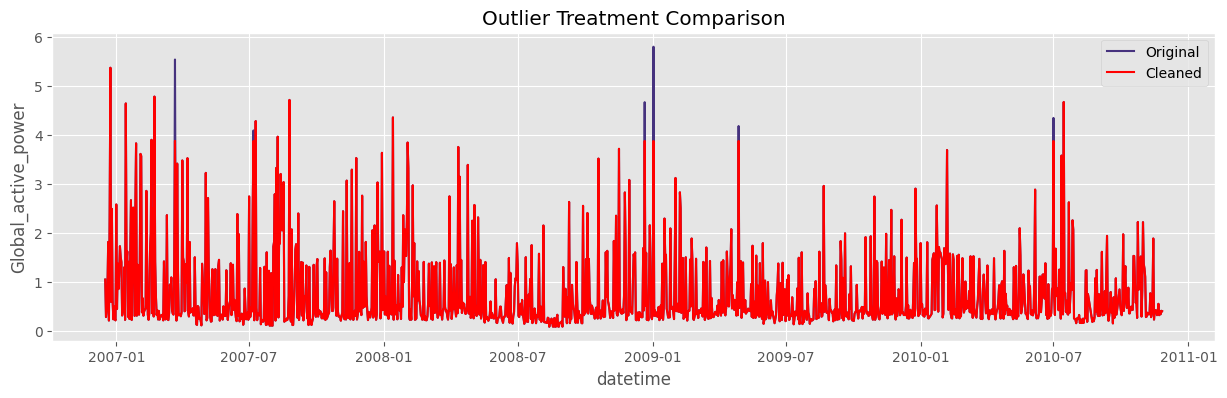

In [34]:
def handle_outliers(series, outliers, method='winsorize', **kwargs):
    """
    Handle detected outliers
    """
    cleaned = series.copy()
    
    if method == 'winsorize':
        # Cap extreme values at percentiles
        lower = kwargs.get('lower', 0.05)
        upper = kwargs.get('upper', 0.95)
        lower_bound = series.quantile(lower)
        upper_bound = series.quantile(upper)
        cleaned[outliers & (series < lower_bound)] = lower_bound
        cleaned[outliers & (series > upper_bound)] = upper_bound
    
    elif method == 'impute':
        # Time-aware imputation
        strategy = kwargs.get('strategy', 'linear')
        cleaned[outliers] = np.nan
        return cleaned.interpolate(method=strategy)
    
    elif method == 'median':
        # Rolling median replacement
        window = kwargs.get('window', 5)
        cleaned[outliers] = np.nan
        return cleaned.fillna(cleaned.rolling(window, min_periods=1).median())
    
    elif method == 'remove':
        # Remove outliers (use with caution)
        return series[~outliers]
    
    else:
        raise ValueError("Invalid method. Choose: 'winsorize', 'impute', 'median', 'remove'")
    
    return cleaned

# 3. Handle outliers using winsorizing
cleaned_ts = handle_outliers(ts, outliers, method='winsorize', lower=0.01, upper=0.99)

# plot the original and cleaned time series using seaborn
plt.figure(figsize=(15, 4))
sns.lineplot(data=ts, label='Original')
sns.lineplot(data=cleaned_ts, label='Cleaned', color='red')
plt.title('Outlier Treatment Comparison')
plt.legend()
plt.show()

- The winsorizing method successfully reduced the impact of extreme outliers
- Data integrity is preserved (no gaps in the time series)
- The underlying patterns remain visible while extreme noise is reduced
- This approach is particularly suitable for energy consumption data where extreme values might represent measurement errors or unusual events


This preprocessing step would make the data more suitable for forecasting models and statistical analysis by reducing the influence of extreme outliers while maintaining the dataset's temporal structure.

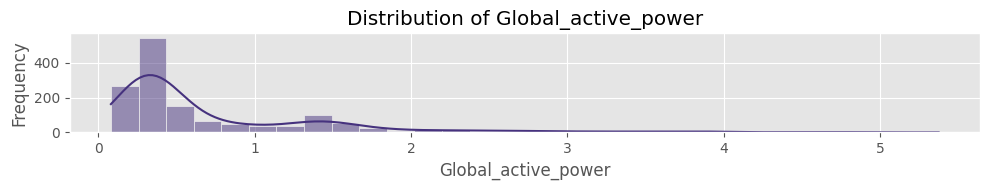

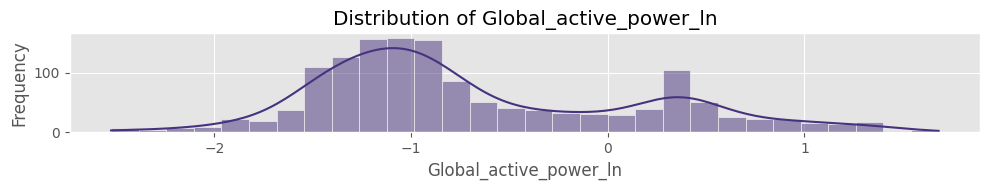

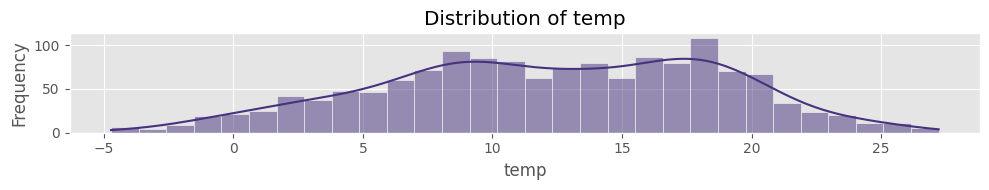

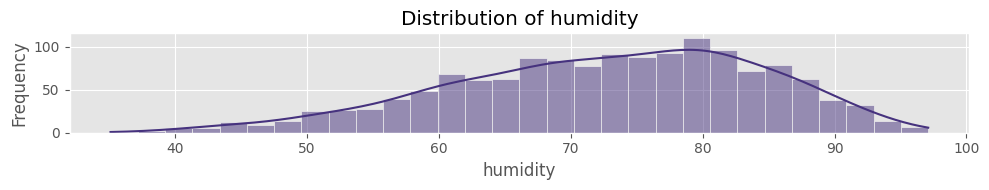

In [41]:
df['Global_active_power'] = cleaned_ts
df['Global_active_power_ln'] = np.log(df['Global_active_power'])

def plot_variable_distribution(df):
    for column in columns:
        fig, ax = plt.subplots(figsize=(10, 2))
        sns.histplot(df[column], kde=True, bins=30, ax=ax)
        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        plt.tight_layout()
        plt.show()

columns = [ 'Global_active_power','Global_active_power_ln','temp','humidity']
plot_variable_distribution(df[columns])


**Normalization Success:**

- The log transformation has successfully converted the highly right-skewed original data into an approximately normal distribution of Global active power
- Much more balanced around the central peak compared to the original distribution
- The long right tail from the original data has been effectively normalized
- Othere important variables are already are normally distributed so we do not need to apply for log normalization.


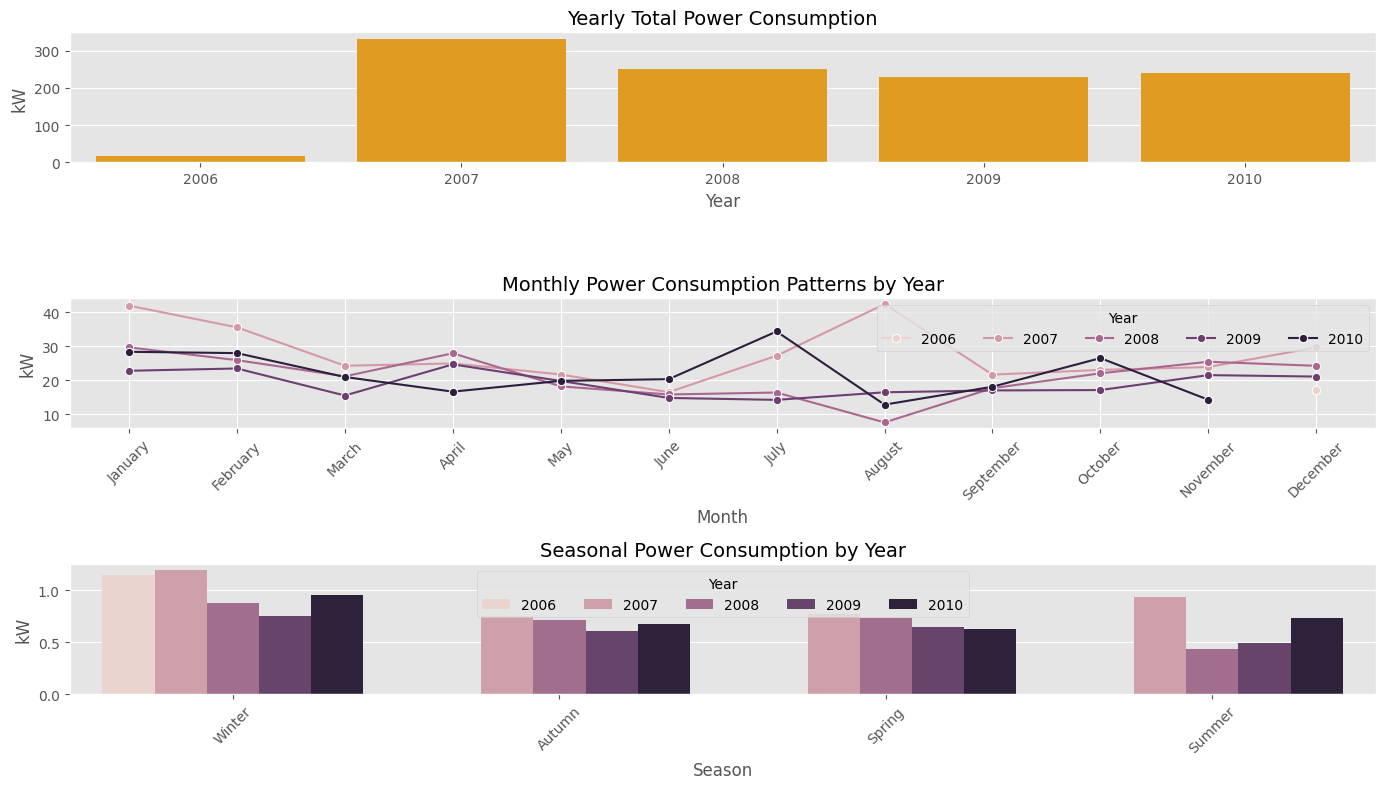

In [73]:

import calendar

# === Yearly and Monthly Analysis ===
fig, ax = plt.subplots(3, 1, figsize=(14, 8))

# Yearly trend
yearly_avg = df.groupby('year')['Global_active_power'].sum()
sns.barplot(x=yearly_avg.index, y=yearly_avg.values, ax=ax[0], color='orange')
ax[0].set_title('Yearly Total Power Consumption', fontsize=14)
ax[0].set_ylabel('kW')
ax[0].set_xlabel('Year')

# Monthly patterns for each year (separate lines for each year)
df['MonthName'] = df['month'].apply(lambda x: calendar.month_name[x])
df['Month'] = df['month']
df['Year'] = df['year']

monthly_avg = df.groupby(['Year', 'MonthName', 'Month'])['Global_active_power'].sum().reset_index()
monthly_avg['MonthName'] = pd.Categorical(monthly_avg['MonthName'], categories=list(calendar.month_name)[1:], ordered=True)

sns.lineplot(x='MonthName', y='Global_active_power', hue='Year', data=monthly_avg, marker='o', ax=ax[1])
ax[1].set_title('Monthly Power Consumption Patterns by Year', fontsize=14)
ax[1].set_ylabel('kW')
ax[1].set_xlabel('Month')
ax[1].tick_params(axis='x', rotation=45)
ax[1].legend(title='Year', loc='upper right', ncol=5)
fig.tight_layout()

# Seasonal decomposition (separate bars for each year)
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                  'Spring' if x in [3, 4, 5] else
                                    'Summer' if x in [6, 7, 8] else
                                        'Autumn')
seasonal_avg = df.groupby(['Year', 'season'])['Global_active_power'].mean().reset_index()

sns.barplot(x='season', y='Global_active_power', hue='Year', data=seasonal_avg, ax=ax[2])
ax[2].set_title('Seasonal Power Consumption by Year', fontsize=14)
ax[2].set_ylabel('kW')
ax[2].set_xlabel('Season')
ax[2].tick_params(axis='x', rotation=45)
ax[2].legend(title='Year', loc='upper center', ncol=5,)
fig.tight_layout()
plt.show()

**2007**: Sharp increase to ~325 kW - full operational year with highest consumption
**2008-2010**: Stabilized around 250 kW annually - consistent consumption pattern established

**Winter months** (Dec-Feb): Generally higher consumption across most years
**Summer months** (Jun-Aug): Lower consumption, particularly evident in 2007 and 2009
**2007 anomaly**: Shows distinctly different pattern with peak in January (~1.4 kW) and lower summer values
**Convergence**: 2008-2010 show more similar monthly patterns, suggesting stabilized usage behavior

- **Winter**: Highest consumption across all years (0.8-1.2 kW)
- **Autumn**: Second highest, relatively stable across years
- **Spring/Summer**: Lower consumption, with summer being lowest in most years
- **Year-over-year stability**: 2008-2010 show very consistent seasonal patterns

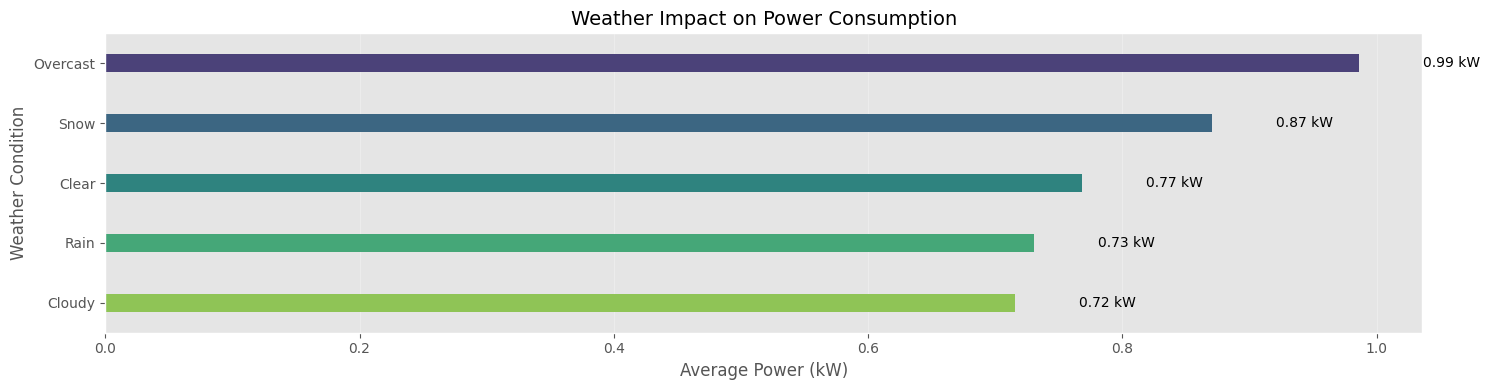

In [ ]:

# === Weather Impact Analysis ===
plt.figure(figsize=(15, 4))

# Weather impact
weather_impact = df.groupby('Weather_Type')['Global_active_power'].mean().sort_values(ascending=False)

sns.barplot(x=weather_impact.values, y=weather_impact.index, hue=weather_impact.index, palette='viridis', width=0.3, legend=False)  # Added `hue`

# Add annotations
for i, v in enumerate(weather_impact.values):
    plt.text(v + 0.05, i, f"{v:.2f} kW", color='black', va='center')
plt.title('Weather Impact on Power Consumption', fontsize=14)
plt.xlabel('Average Power (kW)')
plt.ylabel('Weather Condition')
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### Behavioral & Environmental Factors

**Lighting Requirements:**
- Overcast conditions likely increase artificial lighting needs throughout the day
- Clear days provide natural light, reducing lighting-related consumption


**Thermal Comfort:**
- Snow conditions correlate with colder temperatures, increasing heating demands
- Overcast days may feel colder due to lack of direct sunlight, triggering heating systems


**Indoor Activity :**
- Weather conditions that discourage outdoor activities (overcast, snow) may increase indoor electricity usage
- Clear days might encourage outdoor activities, reducing home electricity consumption

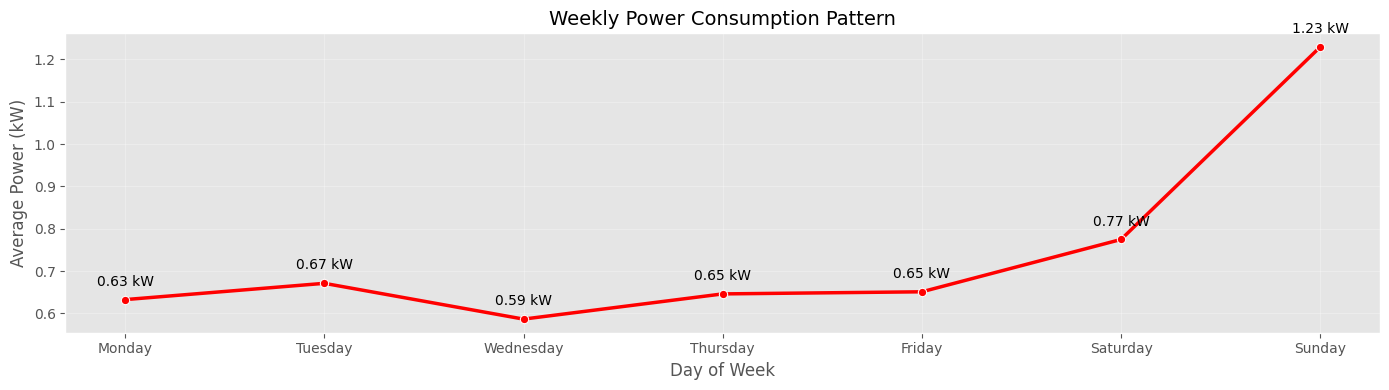

In [ ]:
# === Weekly Patterns ===
plt.figure(figsize=(14, 4))
# Map day_of_week (0=Monday, ..., 6=Sunday) to day names
df['DayName'] = df['day_of_week'].map(dict(enumerate(calendar.day_name)))
weekday_avg = df.groupby('DayName')['Global_active_power'].mean()
weekday_avg = weekday_avg.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
sns.lineplot(x=weekday_avg.index, y=weekday_avg.values, marker='o', linewidth=2.5,color='red')
# Annotationsations
for i, v in enumerate(weekday_avg.values):
    plt.annotate(f"{v:.2f} kW", (i, v), textcoords="offset points", 
                 xytext=(0,10), ha='center')

plt.title('Weekly Power Consumption Pattern', fontsize=14)
plt.ylabel('Average Power (kW)')
plt.xlabel('Day of Week')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weekly_patterns.png', dpi=300)
plt.show()

In [99]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,temp,humidity,day_of_week,...,season_Winter,conditions_Overcast,conditions_Partially cloudy,conditions_Rain,"conditions_Rain, Overcast","conditions_Rain, Partially cloudy","conditions_Snow, Partially cloudy","conditions_Snow, Rain","conditions_Snow, Rain, Overcast","conditions_Snow, Rain, Partially cloudy"
datetime,,,,,,,,,,,,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,3.94,91.1,6,...,True,False,False,False,False,True,False,False,False,False
2006-12-18,0.278,0.126,246.17,1.2,0.0,2.0,0.0,4.39,87.5,0,...,True,False,False,False,False,True,False,False,False,False
2006-12-19,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2.44,78.8,1,...,True,False,True,False,False,False,False,False,False,False
2006-12-20,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2.72,72.3,2,...,True,False,True,False,False,False,False,False,False,False
2006-12-21,1.814,0.148,243.51,7.6,0.0,0.0,18.0,4.83,76.3,3,...,True,False,True,False,False,False,False,False,False,False


<Figure size 1500x1200 with 0 Axes>

<Figure size 1500x1200 with 0 Axes>

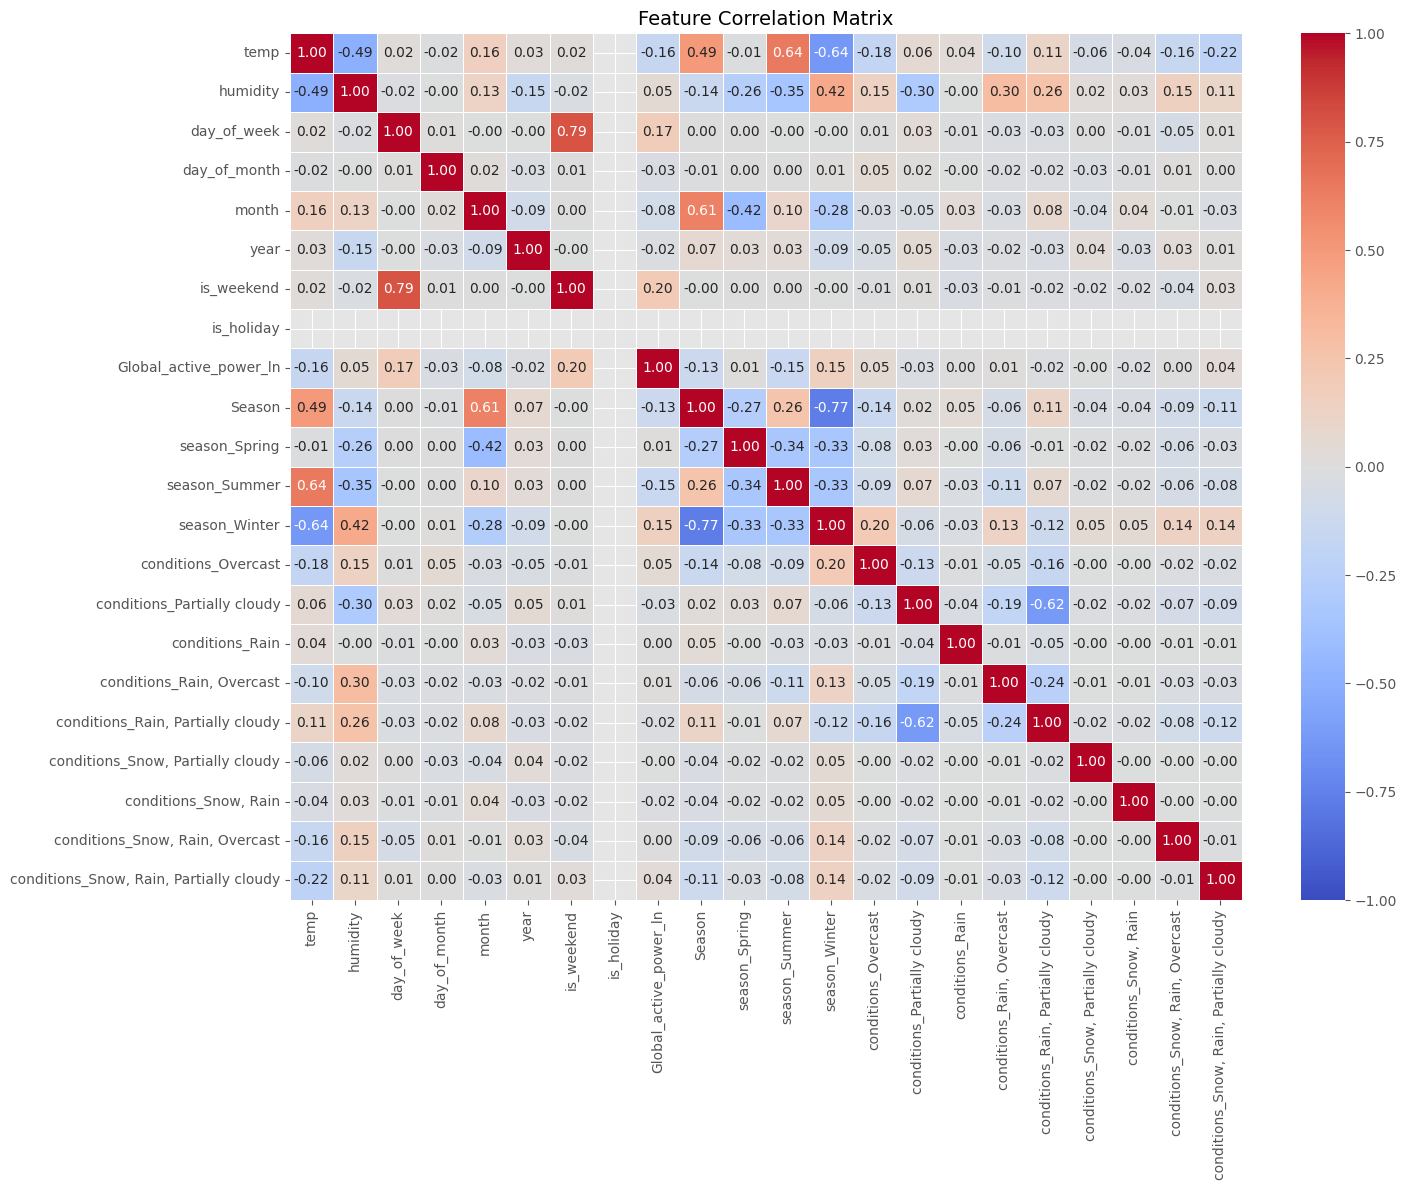

In [105]:
# === Correlation Matrix ===
plt.figure(figsize=(15, 12))

# hot encoding for categorical variables
#df = pd.get_dummies(df, columns=['season', 'conditions'], drop_first=True)

# choose only the environmental variables and power consumption variables
var_to_avoid =["Global_active_power", "Global_reactive_power", "Voltage", "GAP_wh", "sub_metering_total","Sub_metering_1","Sub_metering_2",
               "sub_metering_other","Sub_metering_3","Global_intensity","Monthly","Year",'Month',"DayName","MonthName"]

temp_df = df.copy()

temp_df = temp_df.drop(columns=var_to_avoid, errors='ignore')
# convert boolean columns to integers (if any left)
bool_cols = temp_df.select_dtypes(include=[bool]).columns
temp_df[bool_cols] = temp_df[bool_cols].astype(int)
# Drop non-numeric columns (e.g., 'Weather_Type') before correlation calculation
temp_df = temp_df.select_dtypes(include=[np.number])



corr_matrix = temp_df.corr()
# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=14)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

- The strongest predictor is weekend status (+0.20), indicating people use more energy at home on weekends
- Higher temperatures correlate with lower consumption (-0.16), likely due to reduced heating needs
- Winter shows positive correlation (+0.15) while Summer shows negative (-0.15), confirming heating-driven consumption
- Most weather conditions show weak correlations, with overcast being slightly positive
- Day of week, month, and year show very weak correlations with consumption


The relatively weak correlations (all under 0.20) suggest that energy consumption is influenced not only by temperatural feature  but by multiple factors.

In [125]:
import plotly.subplots as sp
def plot_environmental_factors(df):
    # Create subplots with shared x-axis
    fig = sp.make_subplots(rows=3, cols=1, shared_xaxes=True, subplot_titles=['Temperature', 'Humidity', 'Global Active Power (ln)'], vertical_spacing=0.1) 
    # Temperature plot
    fig.add_trace(go.Scatter(x=df.index, y=df['temp'], mode='lines', name='Temperature', line=dict(color='red', width=2)), row=1, col=1)
    # Humidity plot
    fig.add_trace(go.Scatter(x=df.index, y=df['humidity'], mode='lines', name='Humidity', line=dict(color='blue', width=2)), row=2, col=1)
    # Global Active Power (ln) plot
    fig.add_trace(go.Scatter(x=df.index, y=df['Global_active_power_ln'], mode='lines', name='Global Active Power (ln)', line=dict(color='green', width=2)), row=3, col=1)
    # Update layout
    fig.update_layout(title='Environmental Factors Over Time', xaxis_title='Time', height=800, showlegend=False)
    fig.show()

# Call the function
plot_environmental_factors(df)



**Temperature-Power Relationship:**

- Winter periods (low temperature) appear to coincide with periods of higher power consumption variability
- Summer periods show more stable, lower consumption patterns


**Humidity-Power Relationship:**

- Less clear visual correlation, consistent with the weak correlation (-0.14) found in the correlation matrix


**Temporal Alignment:**

- The different time scales (seasonal for temperature, daily/weekly for power) explain why direct correlations are moderate rather than strong


This visualization confirms that while environmental factors influence energy consumption, the relationship is complex and mediated by human behavior patterns, seasonal heating/cooling needs, and daily activity cycles.

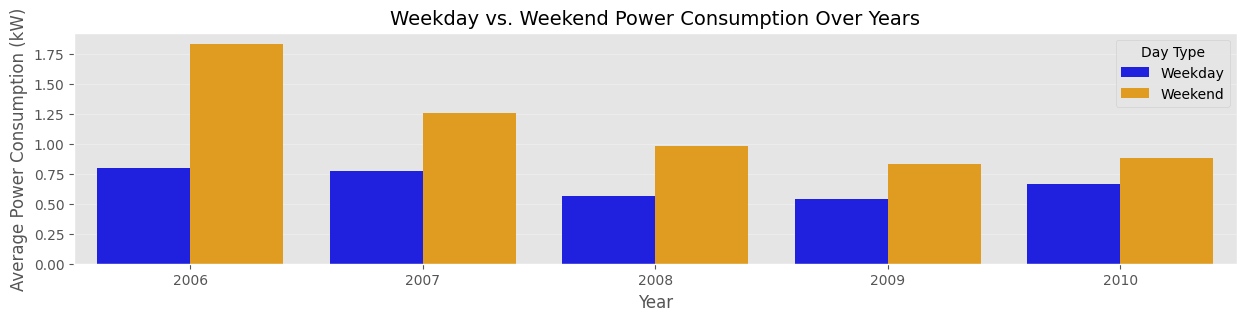

In [136]:


# Group by Year and is_weekend, then calculate average power consumption
yearly_weekend_analysis = df.groupby(['Year', 'is_weekend'])['Global_active_power'].mean().reset_index()

# Rename values for better readability
yearly_weekend_analysis['DayType'] = yearly_weekend_analysis['is_weekend'].map({0: 'Weekday', 1: 'Weekend'})

# Plot the comparison
plt.figure(figsize=(15, 3))
sns.barplot(x='Year', y='Global_active_power', hue='DayType', data=yearly_weekend_analysis, palette=['blue', 'orange'])

plt.title('Weekday vs. Weekend Power Consumption Over Years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Power Consumption (kW)')
plt.legend(title='Day Type')
plt.grid(axis='y', alpha=0.3)

plt.show()


